In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, sem
sns.set()

2023-04-16 22:46:23.459129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 22:46:23.541790: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-04-16 22:46:23.541805: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-16 22:46:23.895468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No s

In [2]:
# Standardized metrics function to use on each model
def get_metrics(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spr = spearmanr(y_true, y_pred)
    return {
        'mse' : mse,
        'r2' : r2,
        'spearman': spearmanr(y_true, y_pred)[0]
    }

In [3]:
def cross_validate_regression(model, x, y, n_splits=10):

    kfold = KFold(n_splits=n_splits)
    
    # metric dict
    _metrics = {'mse': [],
                'r2': [],
                'spearman': []}
    
    for train_idx, test_idx in kfold.split(x, y):
        # build new network
        _model = clone(model)

        # get training data
        x_train = x[train_idx]
        y_true_train = y[train_idx]

        # get testing data
        x_test = x[test_idx]
        y_true_test = y[test_idx]

        # initialize an empty array same size as y_true
        y_pred = np.empty_like(y)

        # train on training data
        _model.fit(x_train, y_true_train)

        # predict testing data
        y_pred = _model.predict(x_test)
        
        # get regression metrics
        metrics_k = get_metrics(y_true_test, y_pred)

        _metrics['mse'].append(metrics_k['mse'])
        _metrics['r2'].append(metrics_k['r2'])
        _metrics['spearman'].append(metrics_k['spearman'])
    
    return _metrics

In [4]:
def cross_validate_regression_network(x, y, embSize, n_splits=10):
    # computes the spearman correlation coefficient for each cross validated data set
    # takes in a model (estimator object), pandas dataframe, x features and the y-feature to predict, as well
    # as the number of splits (default is 10)
    #
    # returns a list of spearman correlation coefficients with length equal to the input n_splits
    

    kfold = KFold(n_splits=n_splits)
    
    # metric dict
    _metrics = {'mse': [],
                'r2': [],
                'spearman': []}
    
    for train_idx, test_idx in kfold.split(x, y):
        # build new network
        backend.clear_session()

        _arch = [
        Flatten(input_shape=(embSize,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
        ]

        model = Sequential(_arch)

        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

        # get training data
        x_train = x[train_idx]
        y_true_train = y[train_idx]

        # get testing data
        x_test = x[test_idx]
        y_true_test = y[test_idx]

        # initialize an empty array same size as y_true
        y_pred = np.empty_like(y)

        # train on training data
        model.fit(x_train, y_true_train, epochs=5, batch_size=32)

        # predict testing data
        y_pred = model.predict(x_test)
        
        # get regression metrics
        metrics_k = get_metrics(y_true_test, y_pred)

        _metrics['mse'].append(metrics_k['mse'])
        _metrics['r2'].append(metrics_k['r2'])
        _metrics['spearman'].append(metrics_k['spearman'])
    
    return _metrics

In [5]:
def w2vEmbedding(texts, embeddingSize=200) -> Word2Vec:
    # Train the Word2Vec model from Gensim. 
    # Below are the hyperparameters that are most relevant. 
    # But feel free to explore other 
    # options too:
    sg = 1 # skip-gram
    window = 5
    vector_size = embeddingSize
    min_count = 1

    model = Word2Vec(sg=sg, window=window, vector_size=vector_size, min_count=min_count)
    model.build_vocab(texts)
    return model

In [6]:
def transformerEmbedding(texts) -> SentenceTransformer:
    bert = SentenceTransformer('distilbert-base-nli-mean-tokens')
    return bert.encode(texts, convert_to_numpy=True)

In [7]:
EMBEDDINGS_SIZE = 25
EMBEDDING_LENGTH_ON = EMBEDDINGS_SIZE * 30 # for the 30-mer sequence
EMBEDDING_LENGTH_OFF = EMBEDDINGS_SIZE * 20 # for the 20-mer off-target sequence


### Preprocessing & Embedding

,Expanded Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.325738,2708.0,0.410978,0,0,0,0,0,1,...,0,0,1,1,0,0,1,1,0,-41
1,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.162559,1558.0,0.236425,1,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,-39
2,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.035653,360.0,0.054586,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,-41
3,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.311042,2602.0,0.394889,0,0,0,0,0,1,...,0,0,1,0,1,0,0,1,0,-42
4,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.199951,1844.0,0.279835,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,-42


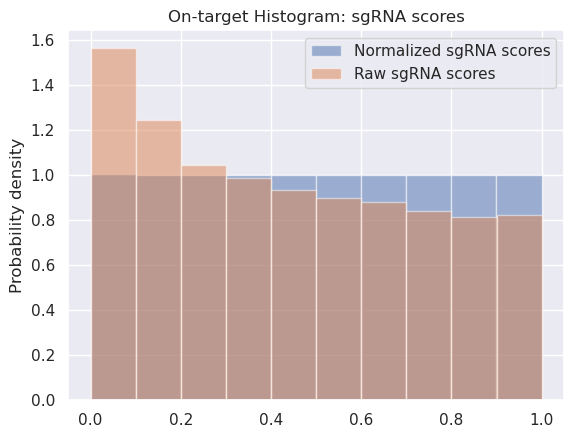

In [8]:
df = pd.read_csv("../data/Doench_Fusi_V2_Featurized.csv", index_col=0)
plt.hist(df["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.hist(df["sgRNA Score"], alpha=0.5, density=True, label='Raw sgRNA scores')
plt.ylabel('Probability density')
plt.title("On-target Histogram: sgRNA scores")
plt.legend()
df.head()

In [9]:
df.shape

(6588, 2495)

,Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,...,TT_PAM,GC Count,Melting Temp Wallace,Melting Temp GC,Melting Temp NN1,Melting Temp NN2,Melting Temp NN3,Melting Temp NN4,GC<10,GC>10
0,TACCCTGGGACTGTACCCCC,215.2632,39133.0,0.604353,0,0,0,0,0,1,...,0,13,66,56,64,58,56,62,0,1
1,ACCCTTGCTGCACGACCTGC,304.1053,47269.0,0.730003,1,0,0,1,0,1,...,0,13,66,56,68,63,59,61,0,1
2,TCGCTCGCCCCGCTCTTCCT,60.7368,14882.0,0.229828,0,0,0,0,0,0,...,0,14,68,58,74,67,62,64,0,1
3,TGACGCCTCGGACGTGTCTG,61.7368,15074.0,0.232793,0,0,0,0,0,1,...,0,13,66,56,67,63,58,59,0,1
4,CGTCATAGCCAATCTTCTTC,116.1053,25878.0,0.399647,0,0,0,0,0,1,...,0,9,58,48,55,53,48,49,1,0


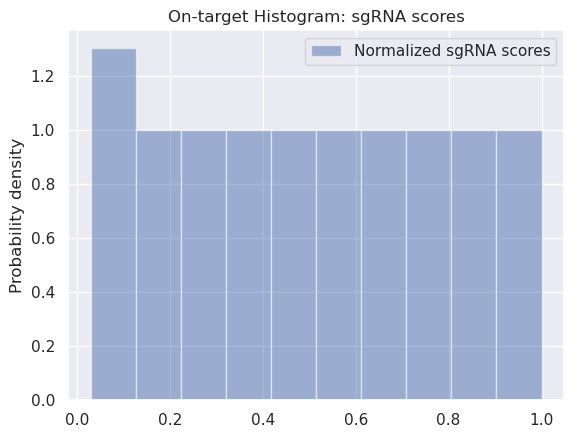

In [10]:
dfOff = pd.read_csv("../data/KO_Data_V1_Featurized.csv", index_col=0)
plt.hist(dfOff["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
# plt.hist(dfOff["sgRNA Score"], alpha=0.5, density=True, label='Raw sgRNA scores')
plt.ylabel('Probability density')
plt.title("On-target Histogram: sgRNA scores")
plt.legend()
dfOff.head()

In [11]:

w2vmodel_sequence = w2vEmbedding(df["Expanded Sequence"], EMBEDDINGS_SIZE)

print('Vocab size {}'.format(len(w2vmodel_sequence.wv)))
vocab_seq = len(w2vmodel_sequence.wv)
w2vmodel_sequence.wv.save_word2vec_format('sequence_embeddings.txt', binary=False)

Vocab size 4


In [12]:
embeddings = []
for _seq in df["Expanded Sequence"]:
    xEmb = []
    for _x in _seq:
        xEmb.extend(w2vmodel_sequence.wv[_x])
    embeddings.append(xEmb)

print(np.array(embeddings).shape)
df["Embedded Sequences"] = embeddings

(6588, 750)


In [13]:
TRANSFORMER_SIZE = 768
trEmb = transformerEmbedding(df["Expanded Sequence"])

df["Transformer Sequences"] = list(trEmb)

dfEmb = df.copy(deep=True)[["Expanded Sequence", "sgRNA Normalized", "Embedded Sequences", "Transformer Sequences"]]
dfEmb.head()

,Expanded Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.410978,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...","[-0.71110904, 0.19907093, 1.3096092, -0.380659..."
1,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.236425,"[-0.03263167, 0.017983193, -0.016548304, 0.003...","[-0.48689786, 0.5684177, 0.88776624, -0.737567..."
2,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.054586,"[-0.03263167, 0.017983193, -0.016548304, 0.003...","[-0.7465677, 0.22358048, 0.9036342, -0.4688507..."
3,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.394889,"[0.0022871399, 0.029767632, -0.003253131, -0.0...","[-0.49734864, 0.27079952, 1.1368276, -0.317906..."
4,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.279835,"[-0.03263167, 0.017983193, -0.016548304, 0.003...","[-0.60272247, -0.121178545, 1.226479, -0.26085..."


In [14]:
dfEmb.to_csv("embedded sequence data.csv")

In [15]:
data = pd.read_csv("embedded sequence data.csv")
dfEmb = data.drop(data.columns[0], axis=1) # drop unnamed column
dfEmb.head()

,Expanded Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.410978,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...",[-7.11109042e-01 1.99070930e-01 1.30960917e+...
1,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.236425,"[-0.03263167, 0.017983193, -0.016548304, 0.003...",[-0.48689786 0.5684177 0.88776624 -0.737567...
2,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.054586,"[-0.03263167, 0.017983193, -0.016548304, 0.003...",[-7.46567726e-01 2.23580480e-01 9.03634191e-...
3,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.394889,"[0.0022871399, 0.029767632, -0.003253131, -0.0...",[-4.97348636e-01 2.70799518e-01 1.13682759e+...
4,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.279835,"[-0.03263167, 0.017983193, -0.016548304, 0.003...",[-6.02722466e-01 -1.21178545e-01 1.22647905e+...


In [16]:

w2vmodel_sequence = w2vEmbedding(dfOff["Sequence"], EMBEDDINGS_SIZE)

print('Vocab size {}'.format(len(w2vmodel_sequence.wv)))
vocab_seq = len(w2vmodel_sequence.wv)
w2vmodel_sequence.wv.save_word2vec_format('sequence_embeddings.txt', binary=False)

embeddings = []
for _seq in dfOff["Sequence"]:
    xEmb = []
    for _x in _seq:
        xEmb.extend(w2vmodel_sequence.wv[_x])
    embeddings.append(xEmb)

print(np.array(embeddings).shape)
dfOff["Embedded Sequences"] = embeddings

trEmb = transformerEmbedding(dfOff["Sequence"])

dfOff["Transformer Sequences"] = list(trEmb)

dfEmbOff = dfOff.copy(deep=True)[["Sequence", "sgRNA Normalized", "Embedded Sequences", "Transformer Sequences"]]
dfEmbOff.head()

Vocab size 4
(64751, 500)


,Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,TACCCTGGGACTGTACCCCC,0.604353,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.6844983, 0.32545617, 1.1369966, -0.2328178..."
1,ACCCTTGCTGCACGACCTGC,0.730003,"[-0.03263167, 0.017983193, -0.016548304, 0.003...","[-0.5825761, 0.11436693, 1.2382472, -0.3425781..."
2,TCGCTCGCCCCGCTCTTCCT,0.229828,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.47986773, 0.014203413, 1.3465703, -0.02461..."
3,TGACGCCTCGGACGTGTCTG,0.232793,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.6668119, 0.12491163, 0.88532573, -0.299219..."
4,CGTCATAGCCAATCTTCTTC,0.399647,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...","[-0.7485277, 0.35522404, 0.9028547, -0.2164551..."


In [17]:
dfEmbOff.to_csv("off-target embedded sequence data.csv")

In [18]:
data = pd.read_csv("off-target embedded sequence data.csv")
dfEmbOff = data.drop(data.columns[0], axis=1) # drop unnamed column
dfEmbOff.head()

,Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,TACCCTGGGACTGTACCCCC,0.604353,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-6.84498310e-01 3.25456172e-01 1.13699663e+...
1,ACCCTTGCTGCACGACCTGC,0.730003,"[-0.03263167, 0.017983193, -0.016548304, 0.003...",[-5.82576096e-01 1.14366934e-01 1.23824716e+...
2,TCGCTCGCCCCGCTCTTCCT,0.229828,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-4.79867727e-01 1.42034134e-02 1.34657025e+...
3,TGACGCCTCGGACGTGTCTG,0.232793,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-6.66811883e-01 1.24911629e-01 8.85325730e-...
4,CGTCATAGCCAATCTTCTTC,0.399647,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...",[-0.7485277 0.35522404 0.9028547 -0.216455...


### On-target Modeling

In [19]:
xRawOn = df.drop(["sgRNA Normalized", "Expanded Sequence", "Embedded Sequences", "Transformer Sequences", "sgRNA Score", "sgRNA Rank"], axis=1).values
xEmbOn = np.array([np.fromstring(_x[1:-1], sep=', ') for _x in dfEmb["Embedded Sequences"].values])
xTrOn = np.array([np.fromstring(_x[1:-1].replace("\n",""), sep=' ') for _x in dfEmb["Transformer Sequences"].values])
yOn = dfEmb["sgRNA Normalized"].values

In [20]:
xRawTrain, xRawTest, xEmbTrain, xEmbTest, xTrTrain, xTrTest, yTrain, yTest = train_test_split(xRawOn, xEmbOn, xTrOn, yOn, test_size=0.1)

In [21]:
model = BayesianRidge()
model.fit(xRawTrain, yTrain)
yPredBrOn = model.predict(xRawTest)

In [22]:
model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_split=5)
model.fit(xRawTrain, yTrain)
yPredGbrtOn = model.predict(xRawTest)

In [23]:
_arch = [
Flatten(input_shape=(EMBEDDING_LENGTH_ON,)),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
yPredEmb = np.empty_like(yTest)

# train on training data
model.fit(xEmbTrain, yTrain, epochs=15, batch_size=32)

# predict testing data
yPredEmbOn = model.predict(xEmbTest)

Epoch 1/15


2023-04-16 22:52:39.771313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-04-16 22:52:39.771327: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-16 22:52:39.771339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pop-os
2023-04-16 22:52:39.771342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pop-os
2023-04-16 22:52:39.771446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-04-16 22:52:39.771466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 52

186/186 [==============================] - 0s 1ms/step - loss: 0.0778
Epoch 2/15
186/186 [==============================] - 0s 1ms/step - loss: 0.0670
Epoch 3/15
186/186 [==============================] - 0s 1ms/step - loss: 0.0653
Epoch 4/15
186/186 [==============================] - 0s 1ms/step - loss: 0.0616
Epoch 5/15
186/186 [==============================] - 0s 1ms/step - loss: 0.0586
Epoch 6/15
186/186 [==============================] - 0s 1ms/step - loss: 0.0545
Epoch 7/15
186/186 [==============================] - 0s 885us/step - loss: 0.0503
Epoch 8/15
186/186 [==============================] - 0s 841us/step - loss: 0.0464
Epoch 9/15
186/186 [==============================] - 0s 814us/step - loss: 0.0428
Epoch 10/15
186/186 [==============================] - 0s 916us/step - loss: 0.0391
Epoch 11/15
186/186 [==============================] - 0s 785us/step - loss: 0.0358
Epoch 12/15
186/186 [==============================] - 0s 827us/step - loss: 0.0330
Epoch 13/15
186/186 [===

In [24]:
_arch = [
Flatten(input_shape=(TRANSFORMER_SIZE,)),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
y_pred = np.empty_like(yTest)

# train on training data
model.fit(xTrTrain, yTrain, epochs=50, batch_size=32)

# predict testing data
yPredTrOn = model.predict(xTrTest)

Epoch 1/50
186/186 [==============================] - 0s 905us/step - loss: 0.0962
Epoch 2/50
186/186 [==============================] - 0s 1ms/step - loss: 0.0830
Epoch 3/50
186/186 [==============================] - 0s 860us/step - loss: 0.0825
Epoch 4/50
186/186 [==============================] - 0s 858us/step - loss: 0.0803
Epoch 5/50
186/186 [==============================] - 0s 991us/step - loss: 0.0816
Epoch 6/50
186/186 [==============================] - 0s 938us/step - loss: 0.0811
Epoch 7/50
186/186 [==============================] - 0s 812us/step - loss: 0.0808
Epoch 8/50
186/186 [==============================] - 0s 814us/step - loss: 0.0797
Epoch 9/50
186/186 [==============================] - 0s 772us/step - loss: 0.0802
Epoch 10/50
186/186 [==============================] - 0s 825us/step - loss: 0.0787
Epoch 11/50
186/186 [==============================] - 0s 843us/step - loss: 0.0792
Epoch 12/50
186/186 [==============================] - 0s 1ms/step - loss: 0.0809
Epoch

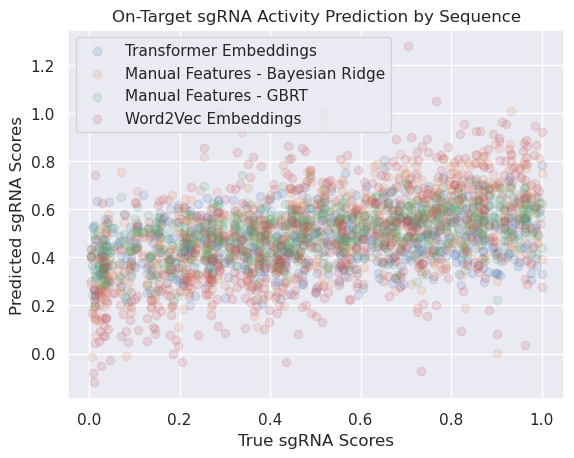

In [25]:
plt.scatter(yTest, yPredTrOn, alpha=0.15, label="Transformer Embeddings")
plt.scatter(yTest, yPredBrOn, alpha=0.15, label="Manual Features - Bayesian Ridge")
plt.scatter(yTest, yPredGbrtOn, alpha=0.15, label="Manual Features - GBRT")
plt.scatter(yTest, yPredEmbOn, alpha=0.15, label="Word2Vec Embeddings")
plt.legend()
plt.ylabel("Predicted sgRNA Scores")
plt.xlabel("True sgRNA Scores")
plt.title("On-Target sgRNA Activity Prediction by Sequence")
plt.savefig("on-target sgrna activity prediction.png")

In [26]:
model = BayesianRidge()
br_metrics = cross_validate_regression(model, xRawOn, yOn)

model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_split=5)
gbrt_metrics = cross_validate_regression(model, xRawOn, yOn)

w2vnn_metrics = cross_validate_regression_network(xEmbOn, yOn, embSize=EMBEDDING_LENGTH_ON)

tfnn_metrics = cross_validate_regression_network(xTrOn, yOn, embSize=TRANSFORMER_SIZE)

Epoch 1/5
186/186 [==============================] - 0s 931us/step - loss: 0.0801
Epoch 2/5
186/186 [==============================] - 0s 942us/step - loss: 0.0660
Epoch 3/5
186/186 [==============================] - 0s 987us/step - loss: 0.0646
Epoch 4/5
186/186 [==============================] - 0s 929us/step - loss: 0.0620
Epoch 5/5
21/21 [==============================] - 0s 420us/step
Epoch 1/5
186/186 [==============================] - 0s 829us/step - loss: 0.0788
Epoch 2/5
186/186 [==============================] - 0s 845us/step - loss: 0.0670
Epoch 3/5
186/186 [==============================] - 0s 859us/step - loss: 0.0654
Epoch 4/5
186/186 [==============================] - 0s 832us/step - loss: 0.0621
Epoch 5/5
21/21 [==============================] - 0s 414us/step
Epoch 1/5
186/186 [==============================] - 0s 880us/step - loss: 0.0762
Epoch 2/5
186/186 [==============================] - 0s 1ms/step - loss: 0.0657
Epoch 3/5
186/186 [==============================] -

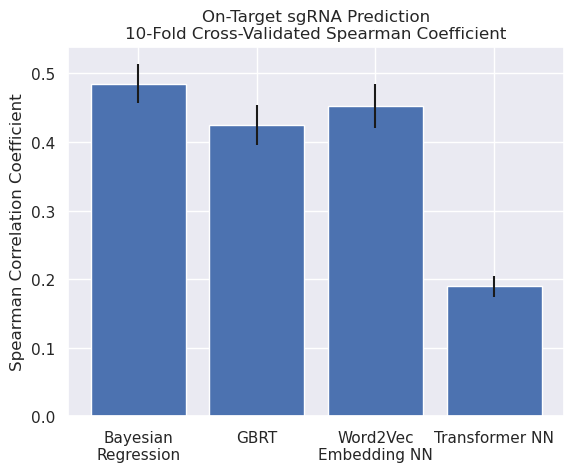

In [27]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("Spearman Correlation Coefficient")
plt.title("On-Target sgRNA Prediction\n10-Fold Cross-Validated Spearman Coefficient")
plt.savefig("on-target sgrna spearman barchart.png")

### Off-target Modeling

In [34]:
xRaw = dfOff.drop(["sgRNA Normalized", "Sequence", "Embedded Sequences", "Transformer Sequences", "sgRNA Score", "sgRNA Rank"], axis=1).values
xEmb = np.array([np.fromstring(_x[1:-1], sep=', ') for _x in dfEmbOff["Embedded Sequences"].values])
xTr = np.array([np.fromstring(_x[1:-1].replace("\n",""), sep=' ') for _x in dfEmbOff["Transformer Sequences"].values])
y = dfOff["sgRNA Normalized"].values

In [35]:
xRawTrain, xRawTest, xEmbTrain, xEmbTest, xTrTrain, xTrTest, yTrain, yTest = train_test_split(xRaw, xEmb, xTr, y, test_size=0.1)

In [36]:
model = BayesianRidge()
model.fit(xRawTrain, yTrain)
yPredBr = model.predict(xRawTest)

In [37]:
model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_split=5)
model.fit(xRawTrain, yTrain)

yPredGbrt = model.predict(xRawTest)

In [38]:
_arch = [
Flatten(input_shape=(EMBEDDING_LENGTH_OFF,)),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
yPredEmb = np.empty_like(yTest)

# train on training data
model.fit(xEmbTrain, yTrain, epochs=5, batch_size=32)

# predict testing data
yPredEmb = model.predict(xEmbTest)

Epoch 1/5
1822/1822 [==============================] - 2s 697us/step - loss: 0.0542
Epoch 2/5
1822/1822 [==============================] - 1s 689us/step - loss: 0.0306
Epoch 3/5
1822/1822 [==============================] - 1s 694us/step - loss: 0.0241
Epoch 4/5
1822/1822 [==============================] - 1s 693us/step - loss: 0.0218
Epoch 5/5
203/203 [==============================] - 0s 364us/step


In [39]:
_arch = [
Flatten(input_shape=(TRANSFORMER_SIZE,)),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
y_pred = np.empty_like(yTest)

# train on training data
model.fit(xTrTrain, yTrain, epochs=5, batch_size=32)

# predict testing data
yPredTr = model.predict(xTrTest)

Epoch 1/5
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0445
Epoch 2/5
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0372
Epoch 3/5
1822/1822 [==============================] - 2s 968us/step - loss: 0.0348
Epoch 4/5
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0332
Epoch 5/5
203/203 [==============================] - 0s 377us/step


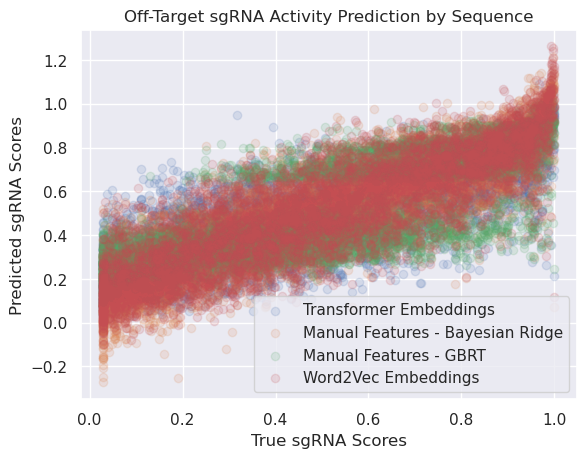

In [40]:
plt.scatter(yTest, yPredTr, alpha=0.15, label="Transformer Embeddings")
plt.scatter(yTest, yPredBr, alpha=0.15, label="Manual Features - Bayesian Ridge")
plt.scatter(yTest, yPredGbrt, alpha=0.15, label="Manual Features - GBRT")
plt.scatter(yTest, yPredEmb, alpha=0.15, label="Word2Vec Embeddings")
plt.legend()
plt.ylabel("Predicted sgRNA Scores")
plt.xlabel("True sgRNA Scores")
plt.title("Off-Target sgRNA Activity Prediction by Sequence")
plt.savefig("off-target sgrna activity prediction.png")

In [41]:
model = BayesianRidge()
br_metrics = cross_validate_regression(model, xRaw, y)

model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_split=5)
gbrt_metrics = cross_validate_regression(model, xRaw, y)

w2vnn_metrics = cross_validate_regression_network(xEmb, y, embSize=EMBEDDING_LENGTH_OFF)

tfnn_metrics = cross_validate_regression_network(xTr, y, embSize=TRANSFORMER_SIZE)

Epoch 1/5
1822/1822 [==============================] - 2s 621us/step - loss: 0.0539
Epoch 2/5
1822/1822 [==============================] - 1s 609us/step - loss: 0.0320
Epoch 3/5
1822/1822 [==============================] - 1s 607us/step - loss: 0.0249
Epoch 4/5
1822/1822 [==============================] - 1s 622us/step - loss: 0.0221
Epoch 5/5
203/203 [==============================] - 0s 381us/step
Epoch 1/5
1822/1822 [==============================] - 2s 717us/step - loss: 0.0529
Epoch 2/5
1822/1822 [==============================] - 2s 840us/step - loss: 0.0309
Epoch 3/5
1822/1822 [==============================] - 1s 754us/step - loss: 0.0247
Epoch 4/5
1822/1822 [==============================] - 1s 782us/step - loss: 0.0221
Epoch 5/5
203/203 [==============================] - 0s 389us/step
Epoch 1/5
1822/1822 [==============================] - 1s 682us/step - loss: 0.0543
Epoch 2/5
1822/1822 [==============================] - 1s 696us/step - loss: 0.0315
Epoch 3/5
1822/1822 [=====

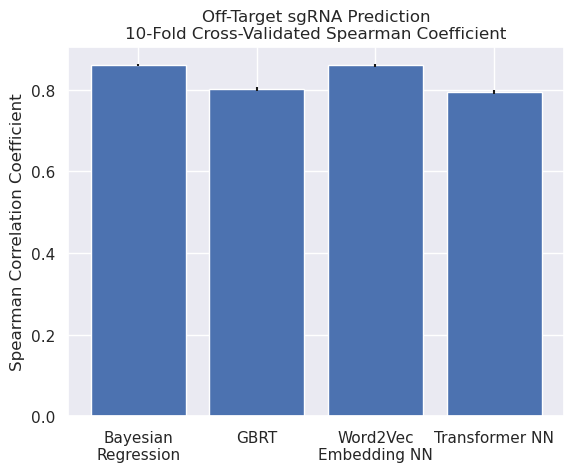

In [42]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("Spearman Correlation Coefficient")
plt.title("Off-Target sgRNA Prediction\n10-Fold Cross-Validated Spearman Coefficient")
plt.savefig("off-target sgrna spearman barchart.png")

### LSTM Modeling

In [ ]:
X_train_seq = [np.array_split(X_train[i], 30) for i in range(X_train.shape[0])]
X_val_seq = [np.array_split(X_val[i], 30) for i in range(X_val.shape[0])]

In [ ]:
X_train_seq

In [ ]:
np.array(X_train_seq).shape

In [ ]:
input_dim = 750  # 4 possible nucleotides
output_dim = 1 # sgRNA score

model = keras.Sequential()
model.add(layers.LSTM(30, input_length=30, input_dim=EMBEDDINGS_SIZE, return_sequences=True))
model.add(layers.LSTM(30))
model.add(layers.Dense(output_dim))

# Compile the model
model.compile(loss='mse', optimizer='adam')

In [ ]:
len(X_train_seq)

In [ ]:
y_train_seq = y_train.reshape(-1, 1)
y_val_seq = y_val.reshape(-1, 1)

In [ ]:
len(y_train)

In [ ]:
# Train the model on the training set
model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val))

# Evaluate the model on the validation set
val_loss = model.evaluate(X_val_seq, y_val)
print("Validation loss:", val_loss)

# Make predictions on the test set (if available)
y_pred = model.predict(X_val_seq)

In [ ]:
# Prepare the testing data
test_sequences = np.array([np.array(list(sequence)) for sequence in test_data['Embedded Sequences']])
test_labels = np.array(test_data['sgRNA Normalized'])

# Evaluate the model
mse, _ = model.evaluate(test_sequences, test_labels)
print('Mean squared error:', mse)